<a href="https://colab.research.google.com/github/abishek2019/DeepLearning/blob/main/Speech_command_clssf_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q tensorflow tensorflow_datasets

In [ ]:
# Note: we did the speech command classification in PyTorch using raw waveform (change in signal amplitude over time)
# but we are doing the same task using the specrtrogram (change in freq magnitude over time)

In [ ]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [ ]:
# seeding
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
# 1. DATA LOAD AND PREPROCESS
# 1a. Get the data
# Each clip belongs to one of the following labels with 16000 time frames (or less) and sr = 16KHz
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

# getting the labels/commands
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['left' 'yes' 'up' 'right' 'no' 'down' 'stop' 'go']


In [ ]:
# 1b. Transform
# Squeezing the mono audio data to remove the 1dim
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

def get_spectrogram(waveform):
  # Converting the waveform to a spectrogram using STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Getting the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a channels dimension (here, at end), so that the spect can be used as image-like i/p data within conv layers (conv expects (bs, c, h, w))
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

def get_spec_ds(ds):
  return ds.map(map_func=lambda audio,label: (get_spectrogram(audio), label), num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# 1c. Batch load
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
# Squeezing the mono audio data
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
# Diving val set into test and val sets
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)
# Creating spectrogram datasets
train_spectrogram_ds = get_spec_ds(train_ds)
val_spectrogram_ds = get_spec_ds(val_ds)
test_spectrogram_ds = get_spec_ds(test_ds)

# using cache and prefetch to reduce latency during model training
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


(64, 16000)
(64,)
Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


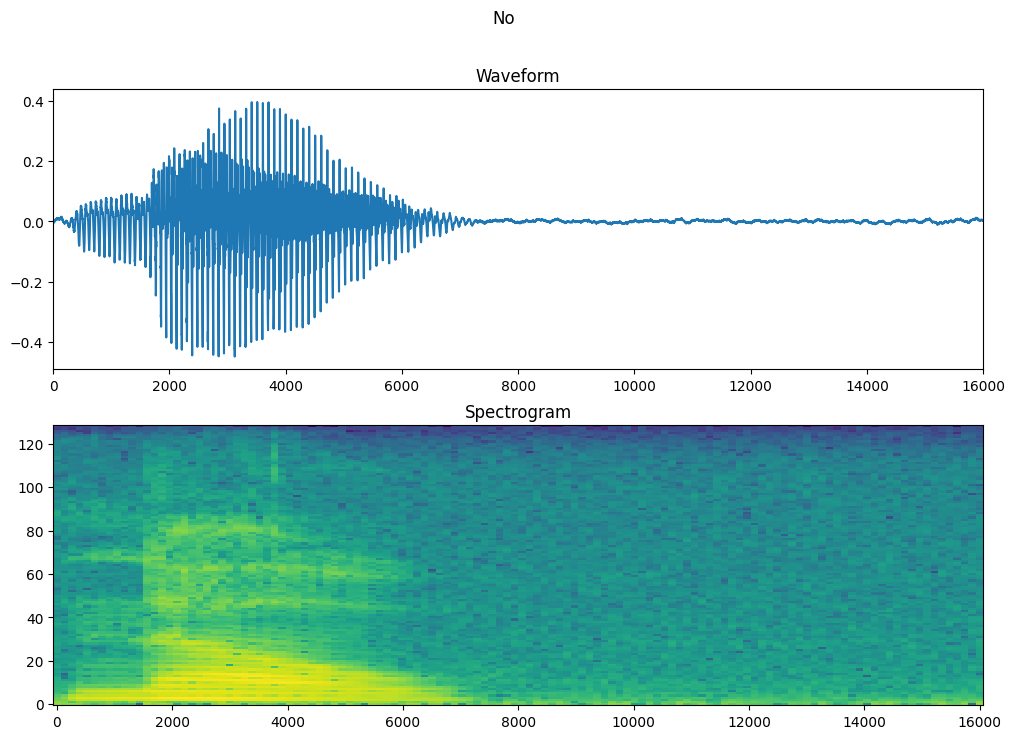

In [ ]:
# Visualizing the data
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and then transpose, so that column (x-axis) represents time axis.
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

# visualising data of train_ds (index 1 shard)
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

# visualizing data in spectrogram_train_ds
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

for input_spectrograms, spect_labels in train_spectrogram_ds.take(1):
  break

In [ ]:
# 2. Define the model
input_shape = input_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the normalization layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms with Normalization.adapt.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)       

In [ ]:
# 3. Deine optimizer and loss function/Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
# 4. Train the model
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 34s 322ms/step - loss: 1.7191 - accuracy: 0.3791 - val_loss: 1.2547 - val_accuracy: 0.6120
Epoch 2/10
100/100 [==============================] - 22s 222ms/step - loss: 1.1463 - accuracy: 0.5961 - val_loss: 0.9315 - val_accuracy: 0.6953
Epoch 3/10
100/100 [==============================] - 30s 297ms/step - loss: 0.8724 - accuracy: 0.6922 - val_loss: 0.7369 - val_accuracy: 0.7448
Epoch 4/10
100/100 [==============================] - 31s 312ms/step - loss: 0.7087 - accuracy: 0.7498 - val_loss: 0.6337 - val_accuracy: 0.8177
Epoch 5/10
100/100 [==============================] - 25s 252ms/step - loss: 0.6024 - accuracy: 0.7862 - val_loss: 0.5746 - val_accuracy: 0.8216
Epoch 6/10
100/100 [==============================] - 23s 226ms/step - loss: 0.5151 - accuracy: 0.8147 - val_loss: 0.5406 - val_accuracy: 0.8385
Epoch 7/10
100/100 [==============================] - 26s 260ms/step - loss: 0.4652 - accuracy: 0.8348 - val_loss: 0.5339 - val_ac

In [ ]:
# 5. Test the model
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 4s 241ms/step - loss: 0.5066 - accuracy: 0.8329


{'loss': 0.5066161751747131, 'accuracy': 0.832932710647583}

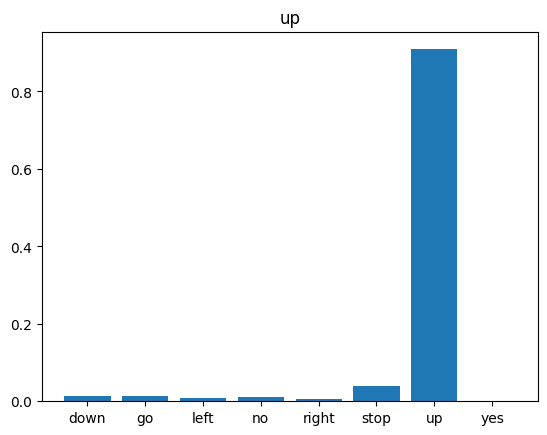

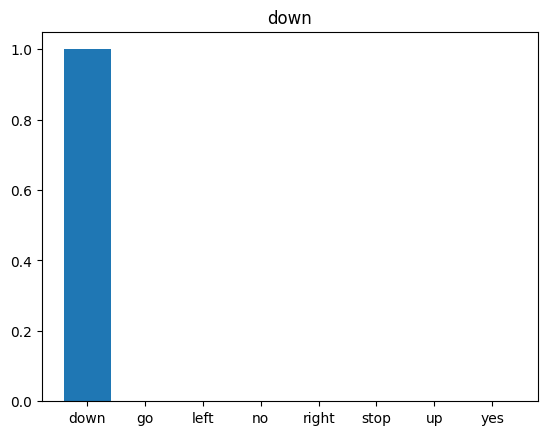

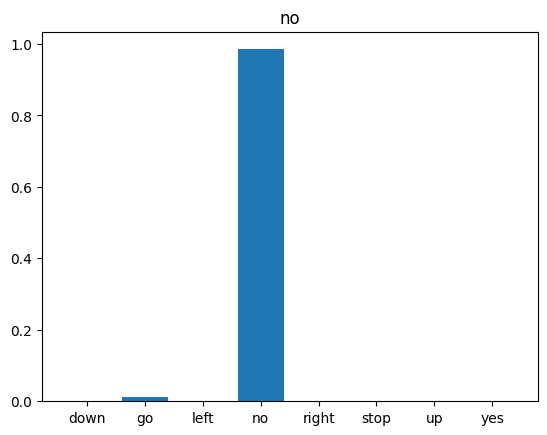

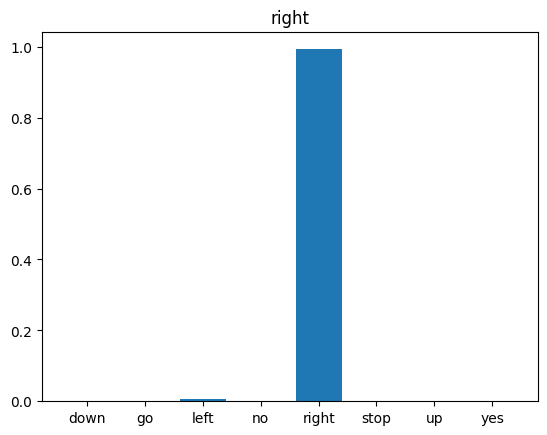

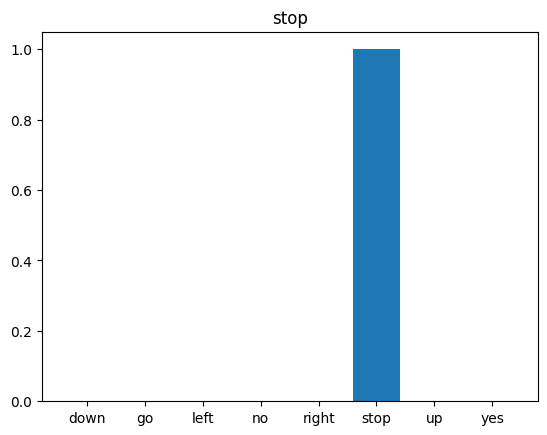

In [ ]:
# 6. Predict
for i in range(5):
  input = example_audio[i]
  actual_label = label_names[example_labels[i]]
  x = get_spectrogram(input)
  x = x[tf.newaxis,...]

  prediction = model(x)
  plt.bar(label_names, tf.nn.softmax(prediction[0]))
  plt.title(actual_label)
  plt.show()

  display.display(display.Audio(input, rate=16000))